In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
import sys

We first want to acquire the image dataset: 

In [2]:
!git clone https://github.com/zalandoresearch/fashion-mnist

fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [3]:
sys.path.append("./fashion-mnist/utils")
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')



In [4]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


Normalizing the training and testing sets:

In [5]:
X_train = X_train - np.mean(X_train, axis = 0)
X_train = X_train / np.std(X_train, axis = 0)

X_test = X_test - np.mean(X_test, axis = 0)
X_test = X_test / np.std(X_test, axis = 0)

Implementation of the MLP class

In [6]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [7]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = 0.5 * np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)
    
class LinearLayerL2(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = 0.5 * np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        #print("Shape of dw:", dw.shape)
        #print("Shape of w:", self.w.shape)
        db = gradient
        #dw -> (6000, 10, 128)
        # w -> (10, 128)
        self.gradient = [dw + 2*0.05*self.w[None, :, :], db] #λ = 0.05
        #print("Shape of self.gradient:", self.gradient.shape)
        #print("Shape of gradient:", gradient.shape)
        return gradient.dot(self.w)

In [8]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
#         print("gradient shape:", self.gradient.shape)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [9]:
class tanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = 1 - (np.tanh(x) * np.tanh(x))
        return np.tanh(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [10]:
class LeakyReLULayer(NeuralNetLayer):
    def init(self):
        super().init()

    def forward(self, x):
        #0.05 is alpha in leakyRelu, hyperparameter
        LeakyReluFcn1 = lambda x1: 1 if x1 > 0 else 0.05
        vectorized1 = np.vectorize(LeakyReluFcn1)
        self.gradient = vectorized1(x)
        
        LeakyReluFcn2 = lambda x2: max(0.05 * x2, x2)
        vectorized2 = np.vectorize(LeakyReluFcn2)
        return vectorized2(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [11]:
#ADDED PRINT STATEMENTS
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        #print(np.amax(x, axis = 1)[:, None])
        #x2 =( x - np.mean(x, axis = 0) ) / np.std(X_train, axis = 0)
        x2 = x - np.amax(x, axis = 1)[:, None]
        #print("\nThis is x:\n", x)
        #print("\nThis is x2:\n", x2)
        exps = np.exp(x2)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [12]:
class Mlp2:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args[0]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
            
  

In [13]:
class Optimizer:
    def __init__(self, net: Mlp2):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: Mlp2, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            # g+=2*λ*self.w
            p -= self.lr * g.mean(axis=0)
            
class GradientDescentOptimizerL2(Optimizer):
    def __init__(self, net: Mlp2, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            #print(self.net.model.w.shape)
            g+= 2*0.05*p   #λ = 0.05
            p -= self.lr * g.mean(axis=0)

In [14]:
#act, hidden layers, number of units, initi
class MLP: 
    def __init__(self, act_fcn, n_features, n_layer = 1, n_units = 64):
        l = []
        if n_layer == 0:
            l.append(LinearLayer(n_features, 10))
            l.append(SoftmaxOutputLayer())
        else:
            l.append(LinearLayer(n_features, n_units))
            l.append(act_fcn())
            
            for i in range(n_layer - 1):
                l.append(LinearLayer(n_units, n_units))
                l.append(act_fcn())
        
            l.append(LinearLayer(n_units, 10))
            l.append(SoftmaxOutputLayer())
        
        self.model = Mlp2(l)
        
    def fit(self, x, y, lr = .05 , max_iterations = 10):
        opt2 = GradientDescentOptimizer(self.model, lr)
        return train(self.model, opt2, x, y, max_iterations)
        
    def predict(self, x):
        return self.model.forward(x)

In [15]:
#act, hidden layers, number of units, initi
class MLPl2_2: 
    def __init__(self, act_fcn, n_features, n_layer = 1, n_units = 64):
        l = []
        if n_layer == 0:
            l.append(LinearLayerL2(n_features, 10))
            l.append(SoftmaxOutputLayer())
        else:
            l.append(LinearLayerL2(n_features, n_units))
            l.append(act_fcn())
            
            for i in range(n_layer - 1):
                l.append(LinearLayerL2(n_units, n_units))
                l.append(act_fcn())
        
            l.append(LinearLayerL2(n_units, 10))
            l.append(SoftmaxOutputLayer())
        
        self.model = Mlp2(l)
        
    def fit(self, x, y, lr = .05 , max_iterations = 10):
        opt2 = GradientDescentOptimizer(self.model, lr)
        return train(self.model, opt2, x, y, max_iterations)
        
    def predict(self, x):
        return self.model.forward(x)
    
class MLPl2: 
    def __init__(self, act_fcn, n_features, n_layer = 1, n_units = 64):
        l = []
        if n_layer == 0:
            l.append(LinearLayer(n_features, 10))
            l.append(SoftmaxOutputLayer())
        else:
            l.append(LinearLayer(n_features, n_units))
            l.append(act_fcn())
            
            for i in range(n_layer - 1):
                l.append(LinearLayer(n_units, n_units))
                l.append(act_fcn())
        
            l.append(LinearLayer(n_units, 10))
            l.append(SoftmaxOutputLayer())
        
        self.model = Mlp2(l)
        
    def fit(self, x, y, lr = .05 , max_iterations = 10):
        opt2 = GradientDescentOptimizerL2(self.model, lr)
        return train(self.model, opt2, x, y, max_iterations)
        
    def predict(self, x):
        return self.model.forward(x)

In [16]:
#ADDED PRINT STATEMENTS

def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps):
    losses = []
    labels = np.eye(10)[np.array(data_y)]
    for i in (range(steps)):
        predictions = mlp.forward(data_x)
        #print(predictions)
        loss = -(labels * np.log(predictions + 0.0000000001)).sum(axis=-1).mean()
        #print(loss)
        losses.append(loss)
        mlp.backward(labels)
        optimizer.step()
        
        #if abs(np.mean(losses[i-10:]) - loss) < 0.1:
         #   break
    
    return losses     


Function to evaluate the accuracy

In [17]:
def evaluate_acc(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

# Experiments

### 1. No hidden layers

0
1
2
3
4


Text(0, 0.5, 'Cross entropy loss')

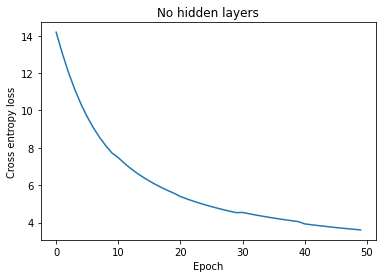

In [18]:
n_feat = X_train.shape[-1]
mlp1 = MLP(act_fcn = ReLULayer, n_features = n_feat, n_layer = 0)

lst1 = []
i = 0
n_mini_batch = 5
while i < n_mini_batch:
    lst1.extend(mlp1.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
    
plt.plot(lst1)
plt.title("No hidden layers")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [19]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_1 = mlp1.predict(X_test)
print(evaluate_acc(y_true, y_pred_1))


0.5586


### 2. Single layer with 128 units and ReLU activations

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

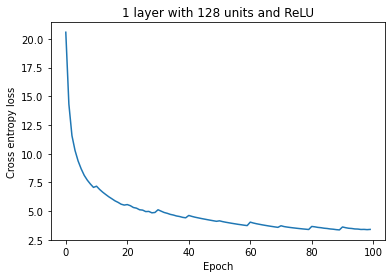

In [20]:
n_feat = X_train.shape[-1]
mlp2 = MLP(act_fcn = ReLULayer, n_features = n_feat, n_layer = 1, n_units = 128)

lst2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst2.extend(mlp2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
    
plt.plot(lst2)
plt.title("1 layer with 128 units and ReLU")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [21]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_2 = mlp2.predict(X_test)
print("Accuracy for a single layer with 128 units (ReLU)", evaluate_acc(y_true, y_pred_2))

Accuracy for a single layer with 128 units (ReLU) 0.7402


### 3. Two layer with 128 units and ReLU activations

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

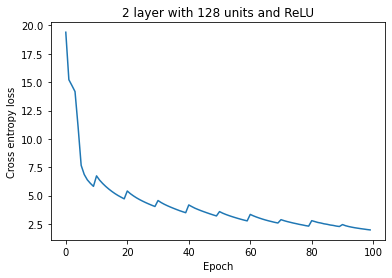

In [22]:
n_feat = X_train.shape[-1]
mlp3 = MLP(act_fcn = ReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst3 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst3.extend(mlp3.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
    
plt.plot(lst3)
plt.title("2 layer with 128 units and ReLU")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [23]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_3 = mlp3.predict(X_test)
print("Accuracy for two layers with 128 units (ReLU)", evaluate_acc(y_true, y_pred_3))

Accuracy for two layers with 128 units (ReLU) 0.6923


### 4. Two layer with 128 units and Tanh activations

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

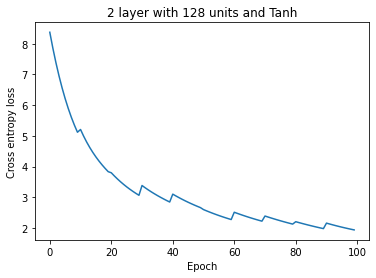

In [24]:
n_feat = X_train.shape[-1]
mlp4 = MLP(act_fcn = tanhLayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst4 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst4.extend(mlp4.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
    
plt.plot(lst4)
plt.title("2 layer with 128 units and Tanh")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [26]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_4 = mlp4.predict(X_test)
print("Accuracy for two layers with 128 units (Tanh)", evaluate_acc(y_true, y_pred_4))

Accuracy for two layers with 128 units (Tanh) 0.5799


#### 0.2 learning rate

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

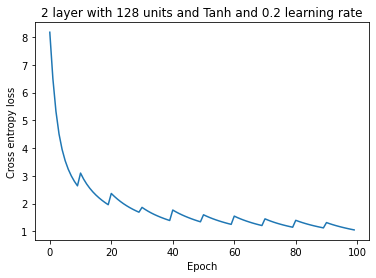

In [28]:
n_feat = X_train.shape[-1]
mlp4 = MLP(act_fcn = tanhLayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst4 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst4.extend(mlp4.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.2))
    print(i)
    i+=1
    
plt.plot(lst4)
plt.title("2 layer with 128 units and Tanh and 0.2 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [29]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_4 = mlp4.predict(X_test)
print("Accuracy for two layers with 128 units (Tanh) and 0.2 learning rate", evaluate_acc(y_true, y_pred_4))

Accuracy for two layers with 128 units (Tanh) and 0.2 learning rate 0.6766


#### 0.35-0.5 learning rate

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

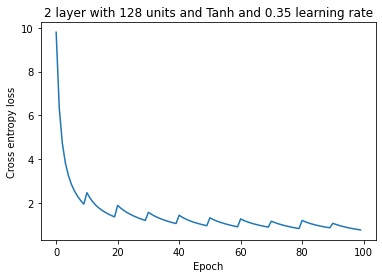

In [30]:
n_feat = X_train.shape[-1]
mlp4 = MLP(act_fcn = tanhLayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst4 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst4.extend(mlp4.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.35))
    print(i)
    i+=1
    
plt.plot(lst4)
plt.title("2 layer with 128 units and Tanh and 0.35 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [31]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_4 = mlp4.predict(X_test)
print("Accuracy for two layers with 128 units (Tanh) and 0.35 learning rate", evaluate_acc(y_true, y_pred_4))

Accuracy for two layers with 128 units (Tanh) and 0.35 learning rate 0.71


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

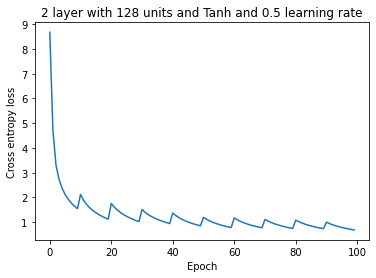

In [32]:
#0.5 learning rate
n_feat = X_train.shape[-1]
mlp4 = MLP(act_fcn = tanhLayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst4 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst4.extend(mlp4.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.5))
    print(i)
    i+=1
    
plt.plot(lst4)
plt.title("2 layer with 128 units and Tanh and 0.5 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [33]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_4 = mlp4.predict(X_test)
print("Accuracy for two layers with 128 units (Tanh) and 0.5 learning rate", evaluate_acc(y_true, y_pred_4))

Accuracy for two layers with 128 units (Tanh) and 0.5 learning rate 0.7178


### 5. Two layer with 128 units and LeakyReLU activations

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

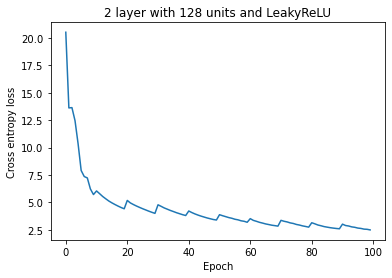

In [34]:
n_feat = X_train.shape[-1]
mlp5 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5.extend(mlp5.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.05))
    print(i)
    i+=1
    
plt.plot(lst5)
plt.title("2 layer with 128 units and LeakyReLU")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [35]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_5 = mlp5.predict(X_test)
print("Accuracy for two layers with 128 units (Leaky-ReLU)", evaluate_acc(y_true, y_pred_5))

Accuracy for two layers with 128 units (Leaky-ReLU) 0.7341


0


<ipython-input-7-ef168e205abc>:13: RuntimeWarning: overflow encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
<ipython-input-7-ef168e205abc>:13: RuntimeWarning: invalid value encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

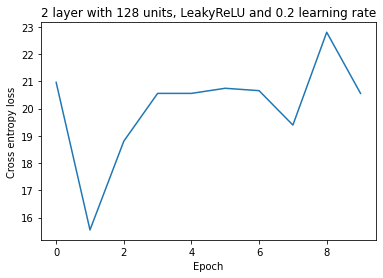

In [36]:
#0.2 learning rate
n_feat = X_train.shape[-1]
mlp5_1 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5_1 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5_1.extend(mlp5_1.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.2))
    print(i)
    i+=1
    
plt.plot(lst5_1)
plt.title("2 layer with 128 units, LeakyReLU and 0.2 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [38]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_5_1 = mlp5_1.predict(X_test)
print("Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.2:", evaluate_acc(y_true, y_pred_5_1))

Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.2: 0.1


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

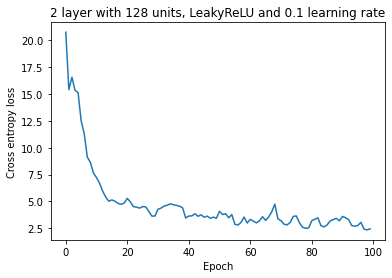

In [39]:
#0.1 learning rate
n_feat = X_train.shape[-1]
mlp5_2 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5_2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5_2.extend(mlp5_2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.1))
    print(i)
    i+=1
    
plt.plot(lst5_2)
plt.title("2 layer with 128 units, LeakyReLU and 0.1 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [40]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_5_2 = mlp5_2.predict(X_test)
print("Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.1:", evaluate_acc(y_true, y_pred_5_2))

Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.1: 0.7551


0


<ipython-input-7-ef168e205abc>:13: RuntimeWarning: overflow encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
<ipython-input-7-ef168e205abc>:13: RuntimeWarning: invalid value encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b


1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

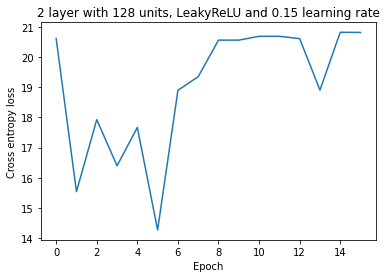

In [20]:
#0.13 learning rate
n_feat = X_train.shape[-1]
mlp5_3 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5_3 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5_3.extend(mlp5_3.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.13))
    print(i)
    i+=1
    
plt.plot(lst5_3)
plt.title("2 layer with 128 units, LeakyReLU and 0.15 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [21]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_5_3 = mlp5_3.predict(X_test)
print("Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.13:", evaluate_acc(y_true, y_pred_5_3))

Accuracy for two layers with 128 units (Leaky-ReLU) and lr = 0.13: 0.1


#### Unnormalized images 

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

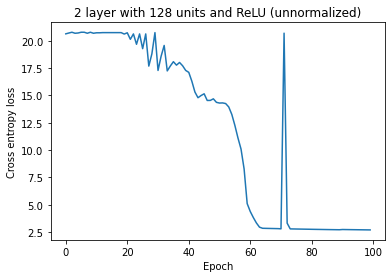

In [22]:
n_feat = X_train.shape[-1]
X_train_un, y_train_un = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test_un, y_test_un = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')


mlp6 = MLP(act_fcn = ReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst6 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst6.extend(mlp6.fit(X_train_un[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train_un[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
    
plt.plot(lst6)
plt.title("2 layer with 128 units and ReLU (unnormalized)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [23]:
y_true = np.eye(10)[np.array(y_test_un)]
y_pred_6 = mlp6.predict(X_test_un)
print("Accuracy for two layers with 128 units (ReLU, unnormalized)", evaluate_acc(y_true, y_pred_6))

Accuracy for two layers with 128 units (ReLU, unnormalized) 0.1


### L2 regularization

1. Modification in optimizer 

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

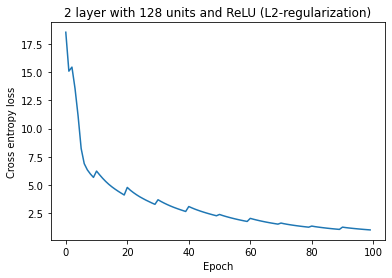

In [24]:
n_feat = X_train.shape[-1]
mlpL2 = MLPl2(act_fcn = ReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lstL2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lstL2.extend(mlpL2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
  
plt.plot(lstL2)
plt.title("2 layer with 128 units and ReLU (L2-regularization)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [25]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_L2 = mlpL2.predict(X_test)
print("Accuracy for two layers with 128 units (ReLU, L2)", evaluate_acc(y_true, y_pred_L2))

Accuracy for two layers with 128 units (ReLU, L2) 0.7251


2. Modification in linearLayer (not adding the biases)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

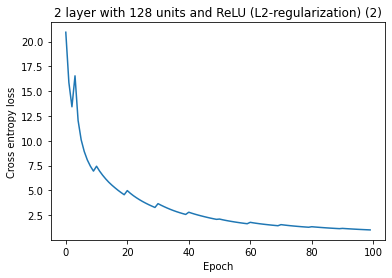

In [26]:
n_feat = X_train.shape[-1]
mlpL2_2 = MLPl2_2(act_fcn = ReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lstL2_2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lstL2_2.extend(mlpL2_2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
  
plt.plot(lstL2_2)
plt.title("2 layer with 128 units and ReLU (L2-regularization) (2)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [27]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_L2_2 = mlpL2_2.predict(X_test)
print("Accuracy for two layers with 128 units (ReLU, L2)", evaluate_acc(y_true, y_pred_L2_2))

Accuracy for two layers with 128 units (ReLU, L2) 0.666


### Small perturbation

In [28]:
x = X_train
y = y_train.reshape((60000, 1))


# small perturbation
w = np.random.randn(1)
w0 = w
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
a1 = w1*x
a2 = w2*x

ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

yh = 1/(1+np.exp(-x * w))
dw_cal = np.sum((yh - y) * x) # hand calculated gradient

print(dw_cal)
print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

5039388.65159287
1191186340.6345806
0.9832200264824431


## Optimizing MLP

Based on the previous experiments, we have seen that Leaky-ReLU is the best activation function, and that a learning rate of 0.1 and the L2 regression give separately better results. Now we want to test the number of hidden layers while setting the learning rate to 0.1 and adding the penaly to the weights using the L2 regression. 

#### a) 3 Hidden layers

<ipython-input-7-ef168e205abc>:13: RuntimeWarning: overflow encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
<ipython-input-7-ef168e205abc>:13: RuntimeWarning: invalid value encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

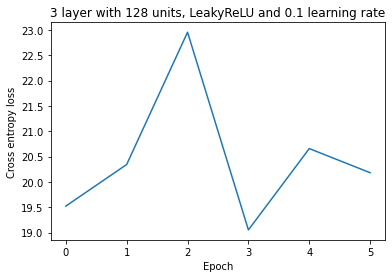

In [29]:
#0.1 learning rate, 3 hidden layers
n_feat = X_train.shape[-1]
mlp3HL = MLPl2(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 3, n_units = 128)

lst3HL = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst3HL.extend(mlp3HL.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.1))
    print(i)
    i+=1
    
plt.plot(lst3HL)
plt.title("3 layer with 128 units, LeakyReLU and 0.1 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [30]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_3HL = mlp3HL.predict(X_test)
print("Accuracy for 3 layers with 128 units (Leaky-ReLU) and lr = 0.1:", evaluate_acc(y_true, y_pred_3HL))

Accuracy for 3 layers with 128 units (Leaky-ReLU) and lr = 0.1: 0.1


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

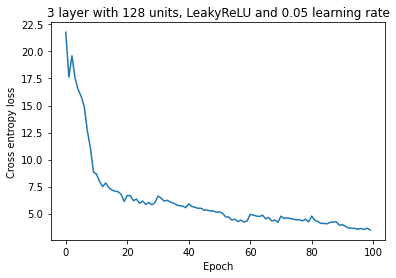

In [21]:
#0.02 learning rate, 3 hidden layers, no L2
n_feat = X_train.shape[-1]
mlp3HL = MLPl2(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 3, n_units = 128)

lst3HL = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst3HL.extend(mlp3HL.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.02))
    print(i)
    i+=1
    
plt.plot(lst3HL)
plt.title("3 layer with 128 units, LeakyReLU and 0.02 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [22]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_3HL = mlp3HL.predict(X_test)
print("Accuracy for 3 layers with 128 units (Leaky-ReLU) and lr = 0.02:", evaluate_acc(y_true, y_pred_3HL))

Accuracy for 3 layers with 128 units (Leaky-ReLU) and lr = 0.02: 0.706


#### 1. L2 + LeakyRelu

In [ ]:
n_feat = X_train.shape[-1]
mlp10 = MLPl2(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst10 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst10.extend(mlp10.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
  
plt.plot(lst10)
plt.title("2 layer with 128 units and LeakyReLU (L2-regularization)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [ ]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_10 = mlp10.predict(X_test)
print("Accuracy for two layers with 128 units (ReLU, L2)", evaluate_acc(y_true, y_pred_10))

#### 1.2 Same, but 64 units

In [ ]:
n_feat = X_train.shape[-1]
mlp11 = MLPl2(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 64)

lst11 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst11.extend(mlp11.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
  
plt.plot(lst11)
plt.title("2 layer with 64 units and LeakyReLU (L2-regularization)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [ ]:
y_true = np.eye(10)[np.array(y_test)]
y_pred_11 = mlp11.predict(X_test)
print("Accuracy for two layers with 64 units (LeakyReLU, L2)", evaluate_acc(y_true, y_pred_11))

#### 2. L2 + 3 layers + LeakyRelu

In [ ]:
n_feat = X_train.shape[-1]
mlp11 = MLPl2(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 3, n_units = 128)

lst11 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst11.extend(mlp11.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)]))
    print(i)
    i+=1
  
plt.plot(lst11)
plt.title("2 layer with 128 units and LeakyReLU (L2-regularization)")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

We have obtained the best result with Leaky-ReLU as activation function, 2 layers and a 0.1 learning rate. Now we will add to the number of iterations to see if the accuracy increases.

<ipython-input-7-ef168e205abc>:13: RuntimeWarning: overflow encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
<ipython-input-7-ef168e205abc>:13: RuntimeWarning: invalid value encountered in matmul
  return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

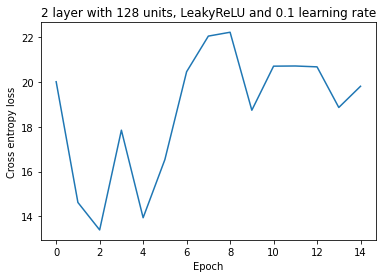

In [18]:
#0.1 learning rate
n_feat = X_train.shape[-1]
mlp5_2 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5_2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5_2.extend(mlp5_2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.1, max_iterations = 20))
    print(i)
    i+=1
    
plt.plot(lst5_2)
plt.title("2 layer with 128 units, LeakyReLU and 0.1 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [19]:
y_true = np.eye(10)[np.array(y_test)]
y_pred = mlp5_2.predict(X_test)
print("Accuracy for 2 layers with 128 units (Leaky-ReLU) and lr = 0.1 and more iterations:", evaluate_acc(y_true, y_pred))

Accuracy for 2 layers with 128 units (Leaky-ReLU) and lr = 0.1 and more iterations: 0.1


Now we change the learning rate to 0.02

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Cross entropy loss')

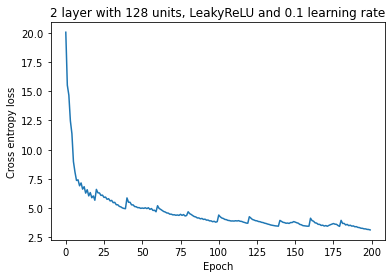

In [20]:
#0.02 learning rate
n_feat = X_train.shape[-1]
mlp5_2 = MLP(act_fcn = LeakyReLULayer, n_features = n_feat, n_layer = 2, n_units = 128)

lst5_2 = []
i = 0
n_mini_batch = 10
while i < n_mini_batch:
    lst5_2.extend(mlp5_2.fit(X_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], y_train[i*int(60000/n_mini_batch): (i+1)*int(60000/n_mini_batch)], lr=0.02, max_iterations = 20))
    print(i)
    i+=1
    
plt.plot(lst5_2)
plt.title("2 layer with 128 units, LeakyReLU and 0.02 learning rate")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [21]:
y_true = np.eye(10)[np.array(y_test)]
y_pred = mlp5_2.predict(X_test)
print("Accuracy for 2 layers with 128 units (Leaky-ReLU) and lr = 0.02 and more iterations:", evaluate_acc(y_true, y_pred))

Accuracy for 2 layers with 128 units (Leaky-ReLU) and lr = 0.02 and more iterations: 0.7587


## CNN

In [64]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
#import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

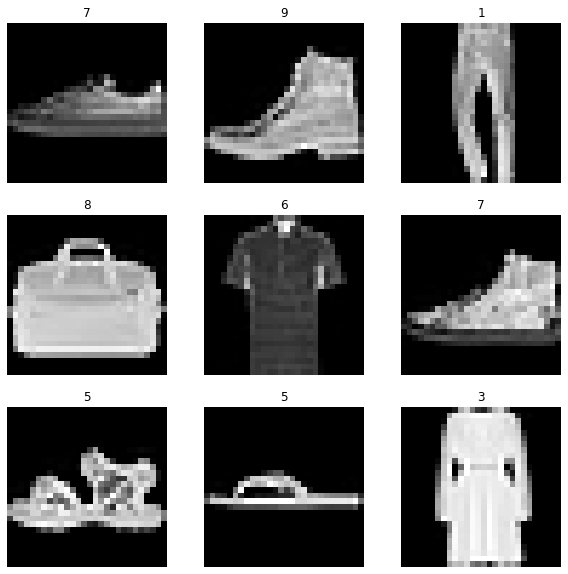

In [65]:
X_tr, y_tr = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_tst, y_tst = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

X_tr = X_tr.reshape((60000, 28, 28))
X_tst = X_tst.reshape((10000, 28, 28))

# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, X_tr.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = X_tr[j], y_tr[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

In [66]:
# Normalizing and reshaping the data**
#First, we normalize the image pixel values from [0, 255] to [-0.5, 0.5]. 
#Second, we reshape the images from (28, 28) to (28, 28, 1) to add the third dimension required by Keras

# Normalize the images
X_tr = (X_tr / 255) - 0.5
X_tst = (X_tst / 255) - 0.5

# Reshape the images.
X_tr = np.expand_dims(X_tr, axis=3)
X_tst = np.expand_dims(X_tst, axis=3)

print(X_tr.shape) # (60000, 28, 28, 1)
print(X_tst.shape)  # (10000, 28, 28, 1)

y_tr = to_categorical(y_tr)
y_tst = to_categorical(y_tst)
print(y_tr.shape) # (60000, 10)
print(y_tst.shape)  # (10000, 10)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [67]:
num_filters = 8 # 10
filter_size = 3 #filter size 4/5
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (X_tr.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
# Different syntax, different padding
model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(128, activation = 'relu'),
  Dense(num_classes, activation='softmax'),
])

In [68]:
# Summary of the model 
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_6 (Flatten)         (None, 2304)             

In [69]:
# Plot model 
tensorflow.keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [70]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [71]:
# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [72]:
# Fitting the model
history = model.fit(
  X_tr,
  y_tr, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_tst, y_tst), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.8268
Epoch 1: val_loss improved from inf to 0.34125, saving model to mnist_best_model.hdf5
938/938 [==============================] - 27s 28ms/step - loss: 0.4741 - accuracy: 0.8269 - val_loss: 0.3412 - val_accuracy: 0.8768
Epoch 2/10
938/938 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8874
Epoch 2: val_loss improved from 0.34125 to 0.29880, saving model to mnist_best_model.hdf5
938/938 [==============================] - 30s 32ms/step - loss: 0.3073 - accuracy: 0.8874 - val_loss: 0.2988 - val_accuracy: 0.8925
Epoch 3/10
937/938 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.9034
Epoch 3: val_loss improved from 0.29880 to 0.27663, saving model to mnist_best_model.hdf5
938/938 [==============================] - 30s 32ms/step - loss: 0.2617 - accuracy: 0.9035 - val_loss: 0.2766 - val_accuracy: 0.8973
Epoch 4/10
937/938 [===========================

In [73]:
# availale keys in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


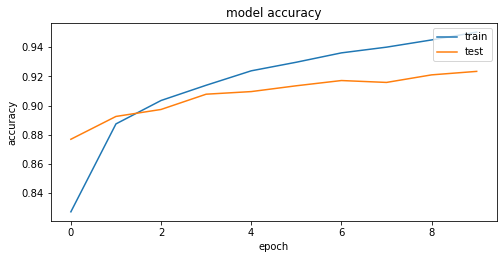

In [74]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

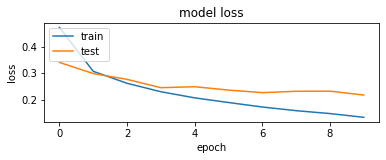

In [75]:
# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 2s 6ms/step
Test error: 7.7%


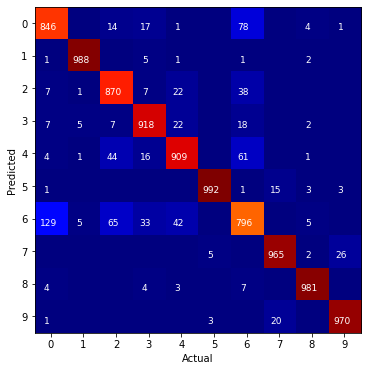

In [77]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(X_tst),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_tst,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### Changing the number of filters

In [35]:
num_filters = 10
filter_size = 3 #filter size 4/5
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (X_tr.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
# Different syntax, different padding
model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(128, activation = 'relu'),
  Dense(num_classes, activation='softmax'),
])

In [36]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)


# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


# Fitting the model
history = model.fit(
  X_tr,
  y_tr, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_tst, y_tst), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.8340
Epoch 1: val_loss improved from inf to 0.32214, saving model to mnist_best_model.hdf5
938/938 [==============================] - 32s 33ms/step - loss: 0.4571 - accuracy: 0.8340 - val_loss: 0.3221 - val_accuracy: 0.8829
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8930
Epoch 2: val_loss improved from 0.32214 to 0.27539, saving model to mnist_best_model.hdf5
938/938 [==============================] - 39s 41ms/step - loss: 0.2934 - accuracy: 0.8929 - val_loss: 0.2754 - val_accuracy: 0.8987
Epoch 3/10
938/938 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9074
Epoch 3: val_loss improved from 0.27539 to 0.24505, saving model to mnist_best_model.hdf5
938/938 [==============================] - 38s 40ms/step - loss: 0.2508 - accuracy: 0.9074 - val_loss: 0.2450 - val_accuracy: 0.9110
Epoch 4/10
937/938 [===========================

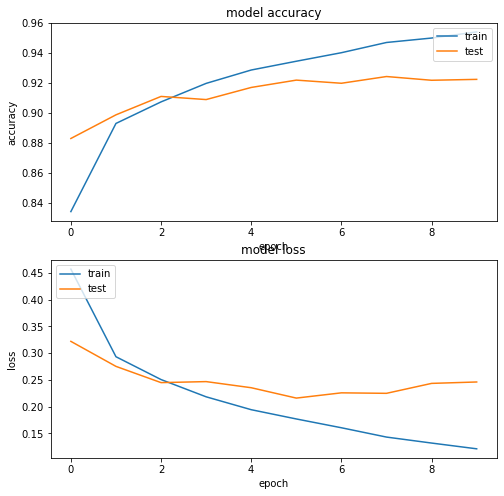

In [37]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 2s 7ms/step
Test error: 7.8%


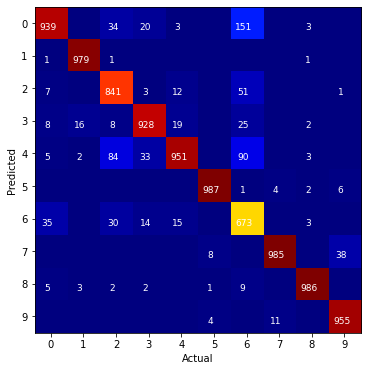

In [39]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(X_tst),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_tst,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### Changing the filter size to 4

In [40]:
num_filters = 8
filter_size = 4 #filter size 4/5
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (X_tr.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
# Different syntax, different padding
model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(128, activation = 'relu'),
  Dense(num_classes, activation='softmax'),
])

In [41]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)


# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


# Fitting the model
history = model.fit(
  X_tr,
  y_tr, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_tst, y_tst), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.8241
Epoch 1: val_loss improved from inf to 0.34479, saving model to mnist_best_model.hdf5
938/938 [==============================] - 38s 39ms/step - loss: 0.4851 - accuracy: 0.8241 - val_loss: 0.3448 - val_accuracy: 0.8766
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8861
Epoch 2: val_loss improved from 0.34479 to 0.28420, saving model to mnist_best_model.hdf5
938/938 [==============================] - 40s 42ms/step - loss: 0.3112 - accuracy: 0.8862 - val_loss: 0.2842 - val_accuracy: 0.8969
Epoch 3/10
937/938 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.9031
Epoch 3: val_loss improved from 0.28420 to 0.26266, saving model to mnist_best_model.hdf5
938/938 [==============================] - 41s 43ms/step - loss: 0.2666 - accuracy: 0.9031 - val_loss: 0.2627 - val_accuracy: 0.9049
Epoch 4/10
937/938 [===========================

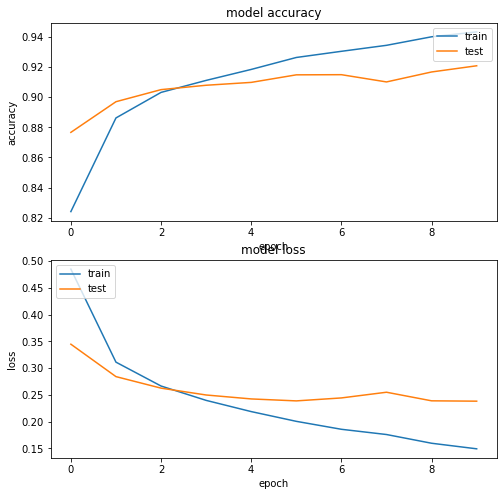

In [42]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 2s 7ms/step
Test error: 7.9%


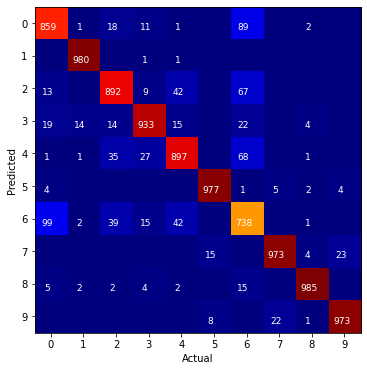

In [44]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(X_tst),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_tst,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### Changing the filter size to 5

In [45]:
num_filters = 8
filter_size = 5 
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (X_tr.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
# Different syntax, different padding
model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(128, activation = 'relu'),
  Dense(num_classes, activation='softmax'),
])

In [46]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)


# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


# Fitting the model
history = model.fit(
  X_tr,
  y_tr, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_tst, y_tst), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8292
Epoch 1: val_loss improved from inf to 0.34373, saving model to mnist_best_model.hdf5
938/938 [==============================] - 49s 51ms/step - loss: 0.4695 - accuracy: 0.8292 - val_loss: 0.3437 - val_accuracy: 0.8771
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8885
Epoch 2: val_loss improved from 0.34373 to 0.28945, saving model to mnist_best_model.hdf5
938/938 [==============================] - 54s 57ms/step - loss: 0.3081 - accuracy: 0.8885 - val_loss: 0.2894 - val_accuracy: 0.8945
Epoch 3/10
937/938 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.9008
Epoch 3: val_loss improved from 0.28945 to 0.26107, saving model to mnist_best_model.hdf5
938/938 [==============================] - 45s 48ms/step - loss: 0.2672 - accuracy: 0.9008 - val_loss: 0.2611 - val_accuracy: 0.9062
Epoch 4/10
937/938 [===========================

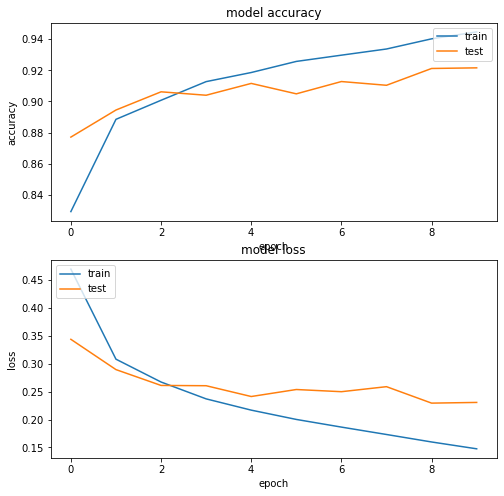

In [47]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 3s 9ms/step
Test error: 7.8%


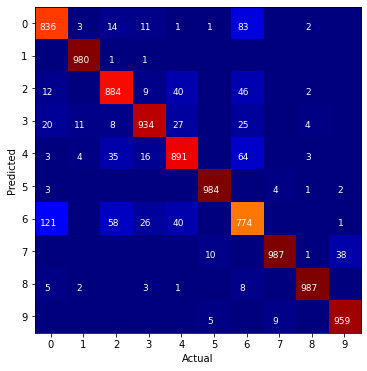

In [49]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(X_tst),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_tst,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### Keeping the padding the same

In [50]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 64
input_shape = (X_tr.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'same' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input
# Different syntax, different padding
model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(128, activation = 'relu'),
  Dense(128, activation = 'relu'),
  Dense(num_classes, activation='softmax'),
])

In [51]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)


# Train the mdoel
# https://keras.io/api/callbacks/

epochs = 10

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


# Fitting the model
history = model.fit(
  X_tr,
  y_tr, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_tst, y_tst), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/10
937/938 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.8271
Epoch 1: val_loss improved from inf to 0.33715, saving model to mnist_best_model.hdf5
938/938 [==============================] - 36s 37ms/step - loss: 0.4767 - accuracy: 0.8271 - val_loss: 0.3371 - val_accuracy: 0.8763
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8862
Epoch 2: val_loss improved from 0.33715 to 0.28337, saving model to mnist_best_model.hdf5
938/938 [==============================] - 34s 36ms/step - loss: 0.3100 - accuracy: 0.8862 - val_loss: 0.2834 - val_accuracy: 0.8960
Epoch 3/10
937/938 [============================>.] - ETA: 0s - loss: 0.2628 - accuracy: 0.9030
Epoch 3: val_loss improved from 0.28337 to 0.25937, saving model to mnist_best_model.hdf5
938/938 [==============================] - 33s 35ms/step - loss: 0.2628 - accuracy: 0.9031 - val_loss: 0.2594 - val_accuracy: 0.9065
Epoch 4/10
938/938 [===========================

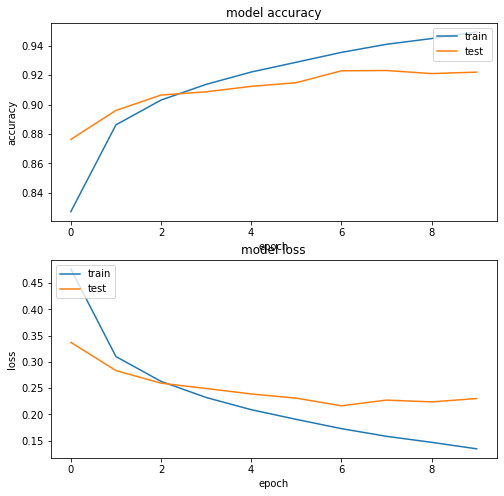

In [52]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 2s 7ms/step
Test error: 7.8%


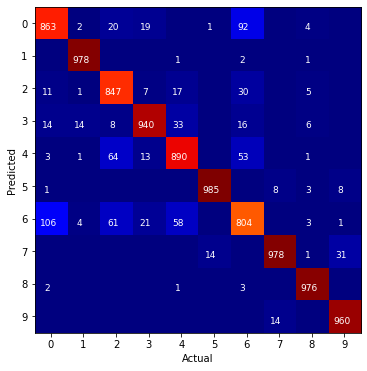

In [54]:
# Model predictions and confusion matrix
test_predictions          = np.argmax(model.predict(X_tst),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_tst,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')